# Hands-on Activity 5.1 Generating Images with GANs and VAEs

## Procedures and Discussion: Variational Autoencoders and GANs

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from keras.layers import *
from keras import backend as K

# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#

print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Part 1: Autoencoders (AEs)

Answer: What is the typical architecture of a 'vanilla/standard/traditional' autoencoder.

#### **The typical architecture of a 'vanilla/standard/traditional' autoencoder includes encoder, a decoder, and a loss function. The encoder compresses input data into a lower-dimensional representation by using layers with activation functions like ReLU. Then, the decoder attempts to reconstruct the original input data from this encoded representation, using layers in reverse order. Throughout training, the goal is to minimize the loss by using MSE or BCE.**

### Data: Acquisition and Pre-processing
We will be using Fashion-MNIST, which can be conveniently accessed with Keras.

4422102/4422102 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


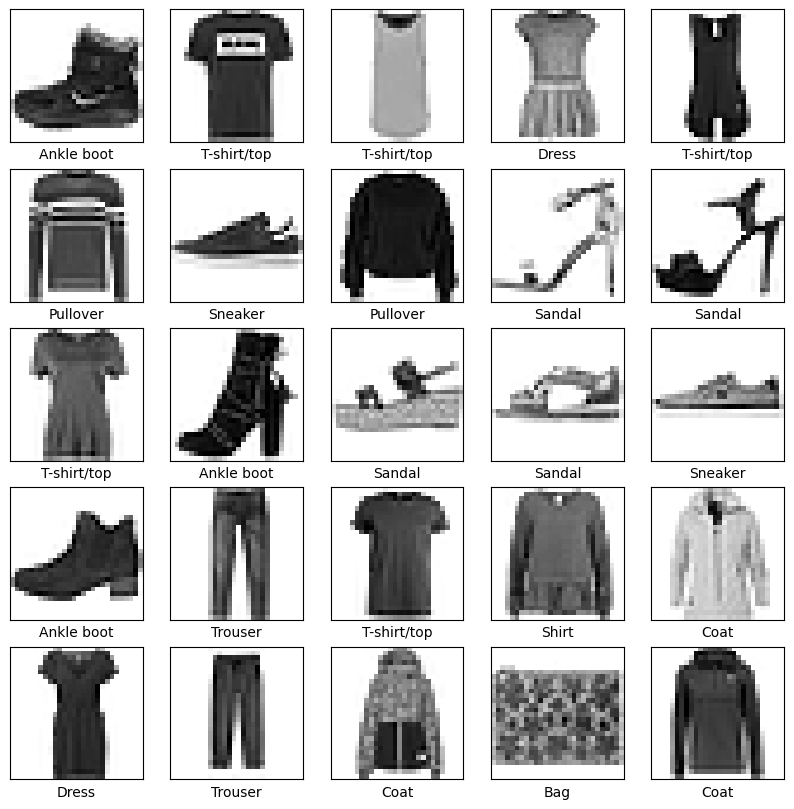

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display the first 25 garments from the training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Add Noise to the Images

In attempt to make the autoencoder more robust and not just memorize the inputs, let's add noise to the inputs but calculate its loss based on how similar its outputs are to the original (non-denoised) images.

Check out imgaug docs for more info and other ways to add noise.

In [ ]:
# Neural Networks want the inputs to be 3D
n_samples, h, w = X_train.shape

X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

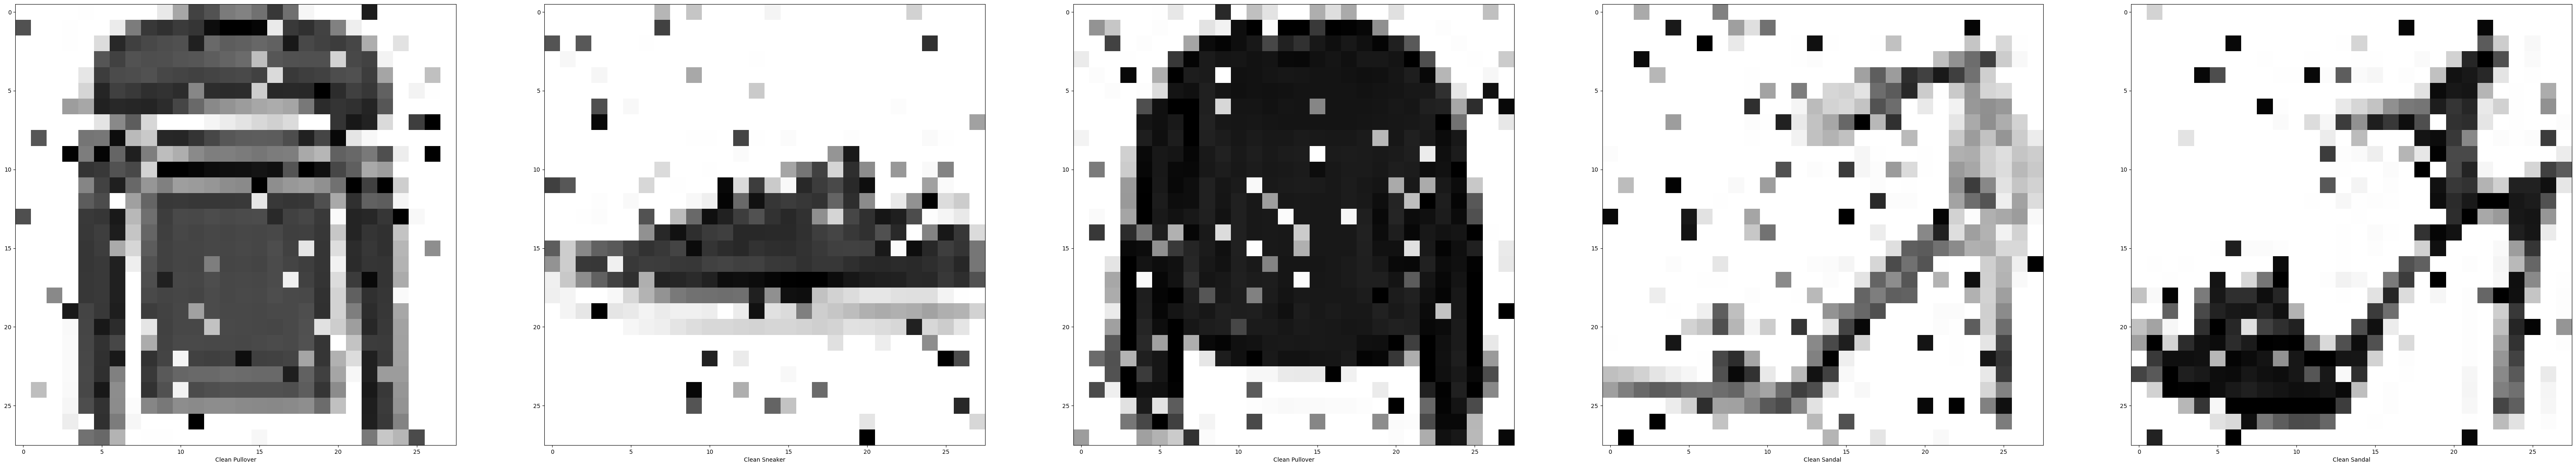

In [ ]:
# Adding some 'salt and pepper' noises
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### Create the Autoencoder

In [ ]:
# input layer
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer3)
output_layer = tf.keras.layers.Conv2D(1,(3, 3), padding='same')(decoded_layer3)

# compile the model
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

#### Train the Autoencoder

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

# epochs=20 for better results
history = model.fit(X_train_n, X_train, epochs=20, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 234us/sample - loss: 0.0707 - val_loss: 0.0431
Epoch 2/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0370 - val_loss: 0.0322
Epoch 3/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0297 - val_loss: 0.0272
Epoch 4/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0265 - val_loss: 0.0250
Epoch 5/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0242 - val_loss: 0.0234
Epoch 6/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0228 - val_loss: 0.0222
Epoch 7/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0218 - val_loss: 0.0213
Epoch 8/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0214 - val_loss: 0.0207
Epoch 9/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0204 - va

In [ ]:
n = np.random.randint(0,len(X_test)-5) # pick a random starting index within our test set

#### Visualize Samples reconstructed by AE

**Denoised Images**

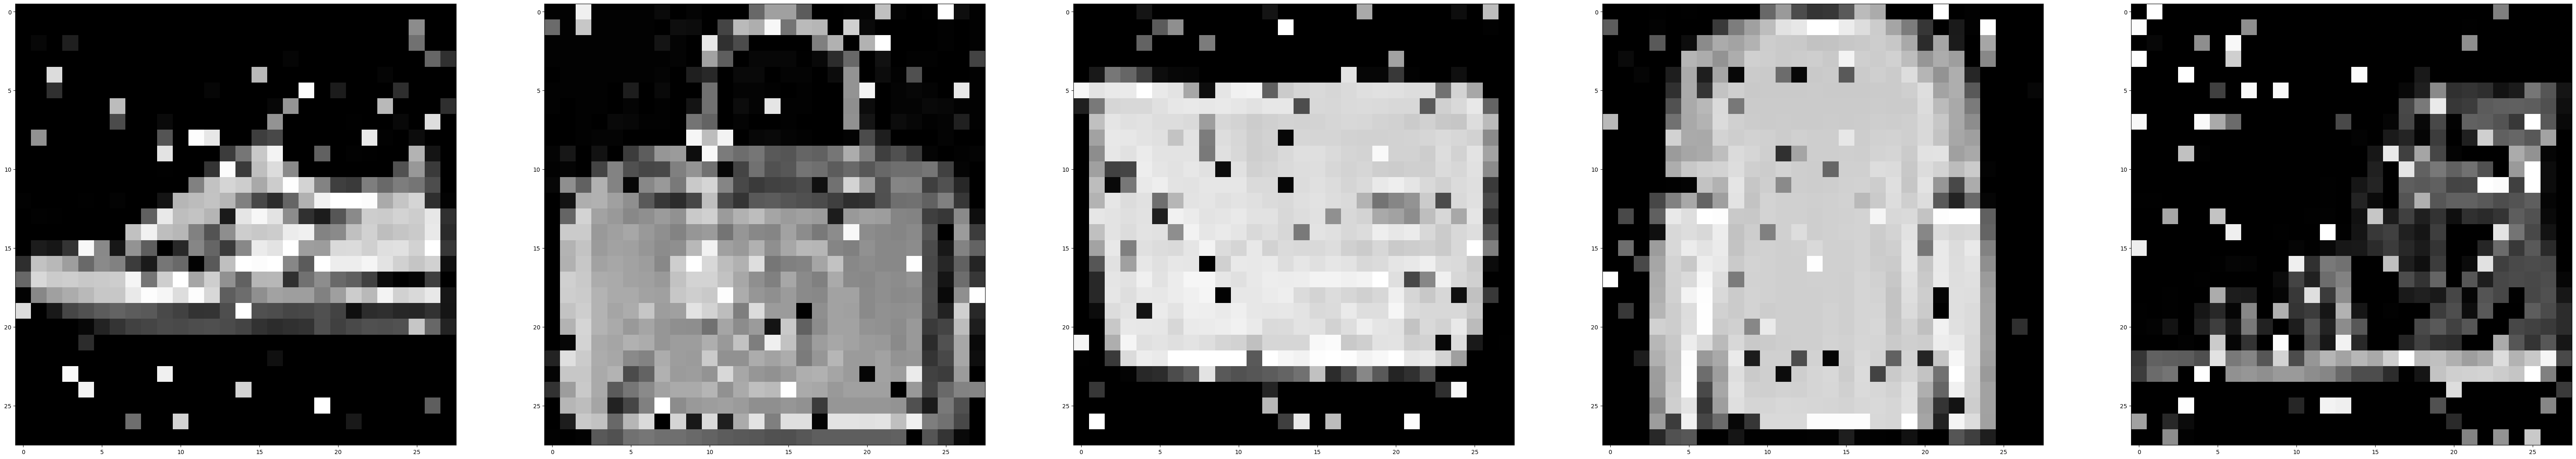

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

**Actual Targets (i.e., Original inputs)**

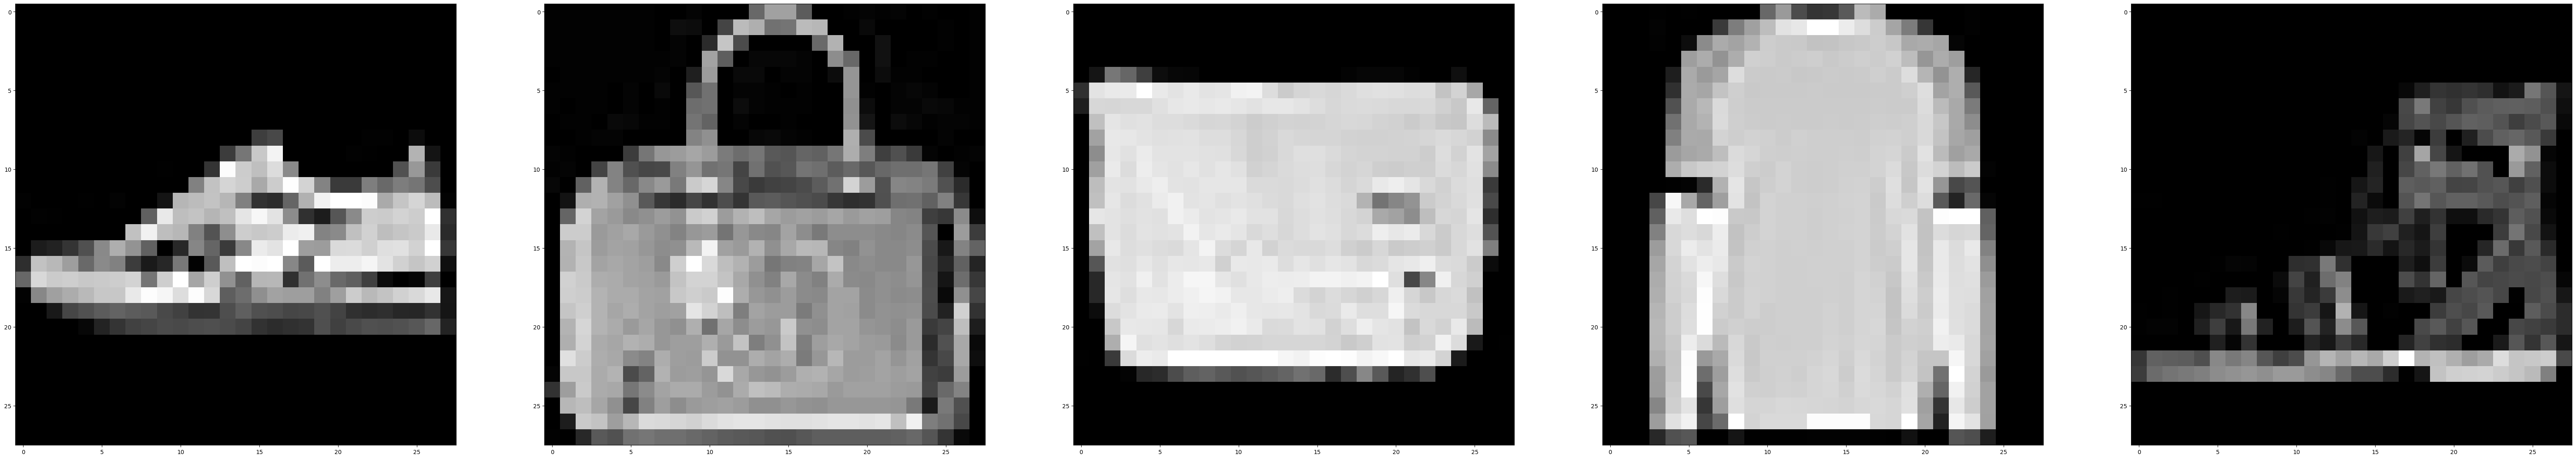

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)): # display the 5 images starting at our random index
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

**Predicted Images**

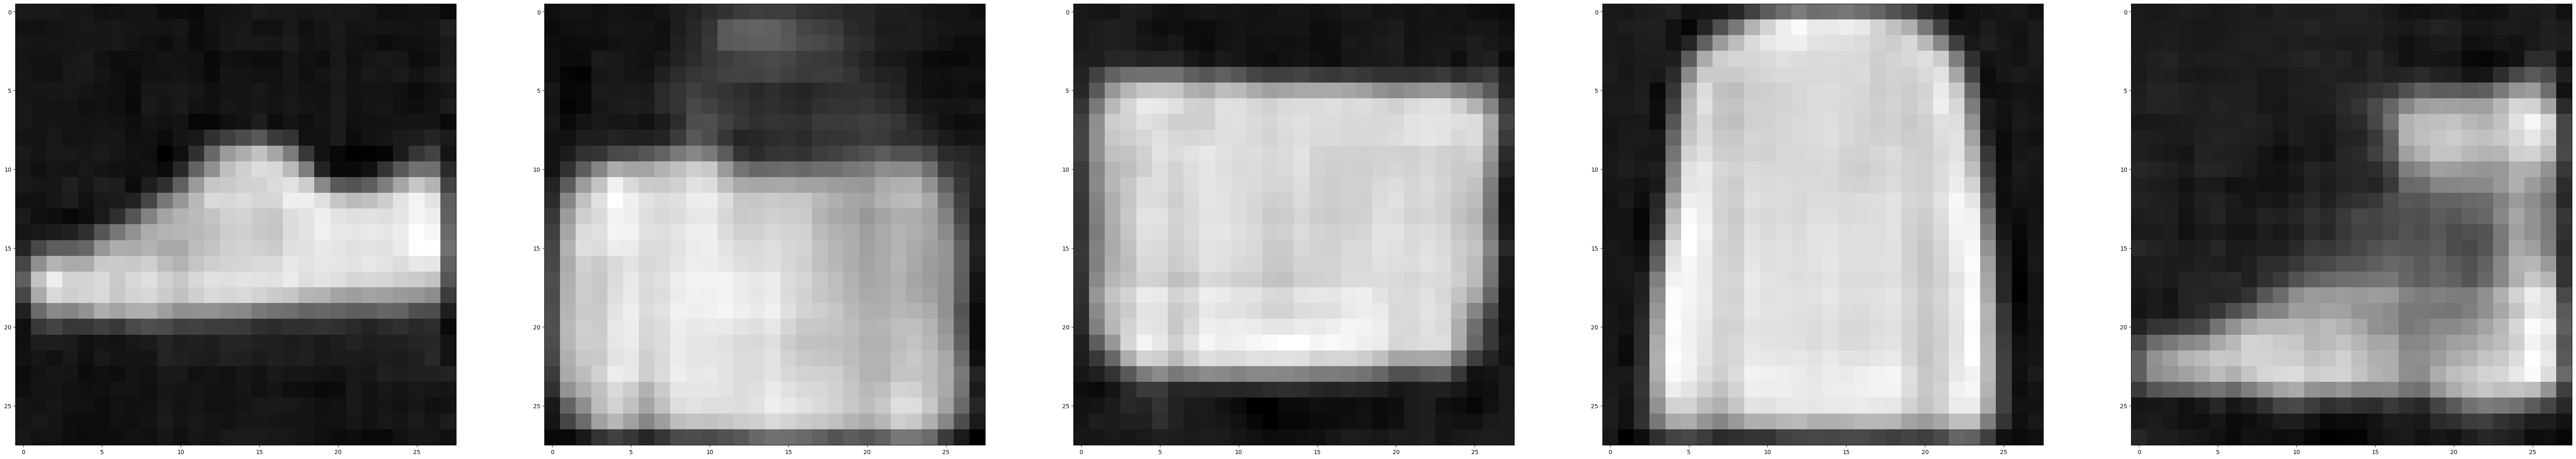

In [ ]:
preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

#### **When observing the predicted images, they have almost similar structure from the original. The result is somewhat good knowing that they were trained with the noisy inputs. This means that the autoencoder effectively learns to denoise and recreate the features of the images.**

## Part 2: Variational Autoencoders (VAEs)

**Discussion: Why do we care to use VAEs? Identify the limitations/weaknesses of Autoencoders**

#### **We use Variational Autoencoders (VAEs) because they not only compress data like traditional autoencoders but also generate new data points. Also, traditional autoencoders lack the ability to generate meaningful variations or explore the latent space. However, autoencoders, including VAEs, have limitations such as the difficulty in controlling the generation process to produce desired outputs and the challenge of preserving precise details in reconstructions, particularly for complex data like images.**

### Reset Data

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


### Setup Encoder Neural Network

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dens  (None, 512)               1536      
 e)                                                              
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

<tf.Tensor 'model_1/original_decoder/Sigmoid:0' shape=(None, 784) dtype=float32>

In [ ]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 intermediate_encoder (Dens  (None, 512)                  401920    ['input[0][0]']               
 e)                                                                                               
                                                                                                  
 latent_encoder (Dense)      (None, 2)                    1026      ['intermediate_encoder[0][0]']
                                                                                                  
 dense (Dense)               (None, 2)                    6         ['latent_encoder[0][0]']

In [ ]:
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 18s 293us/sample - loss: 0.3764 - val_loss: 0.3565
Epoch 2/4
60000/60000 [==============================] - 12s 207us/sample - loss: 0.3445 - val_loss: 0.3435
Epoch 3/4
60000/60000 [==============================] - 13s 210us/sample - loss: 0.3406 - val_loss: 0.3425
Epoch 4/4
60000/60000 [==============================] - 14s 240us/sample - loss: 0.3385 - val_loss: 0.3403


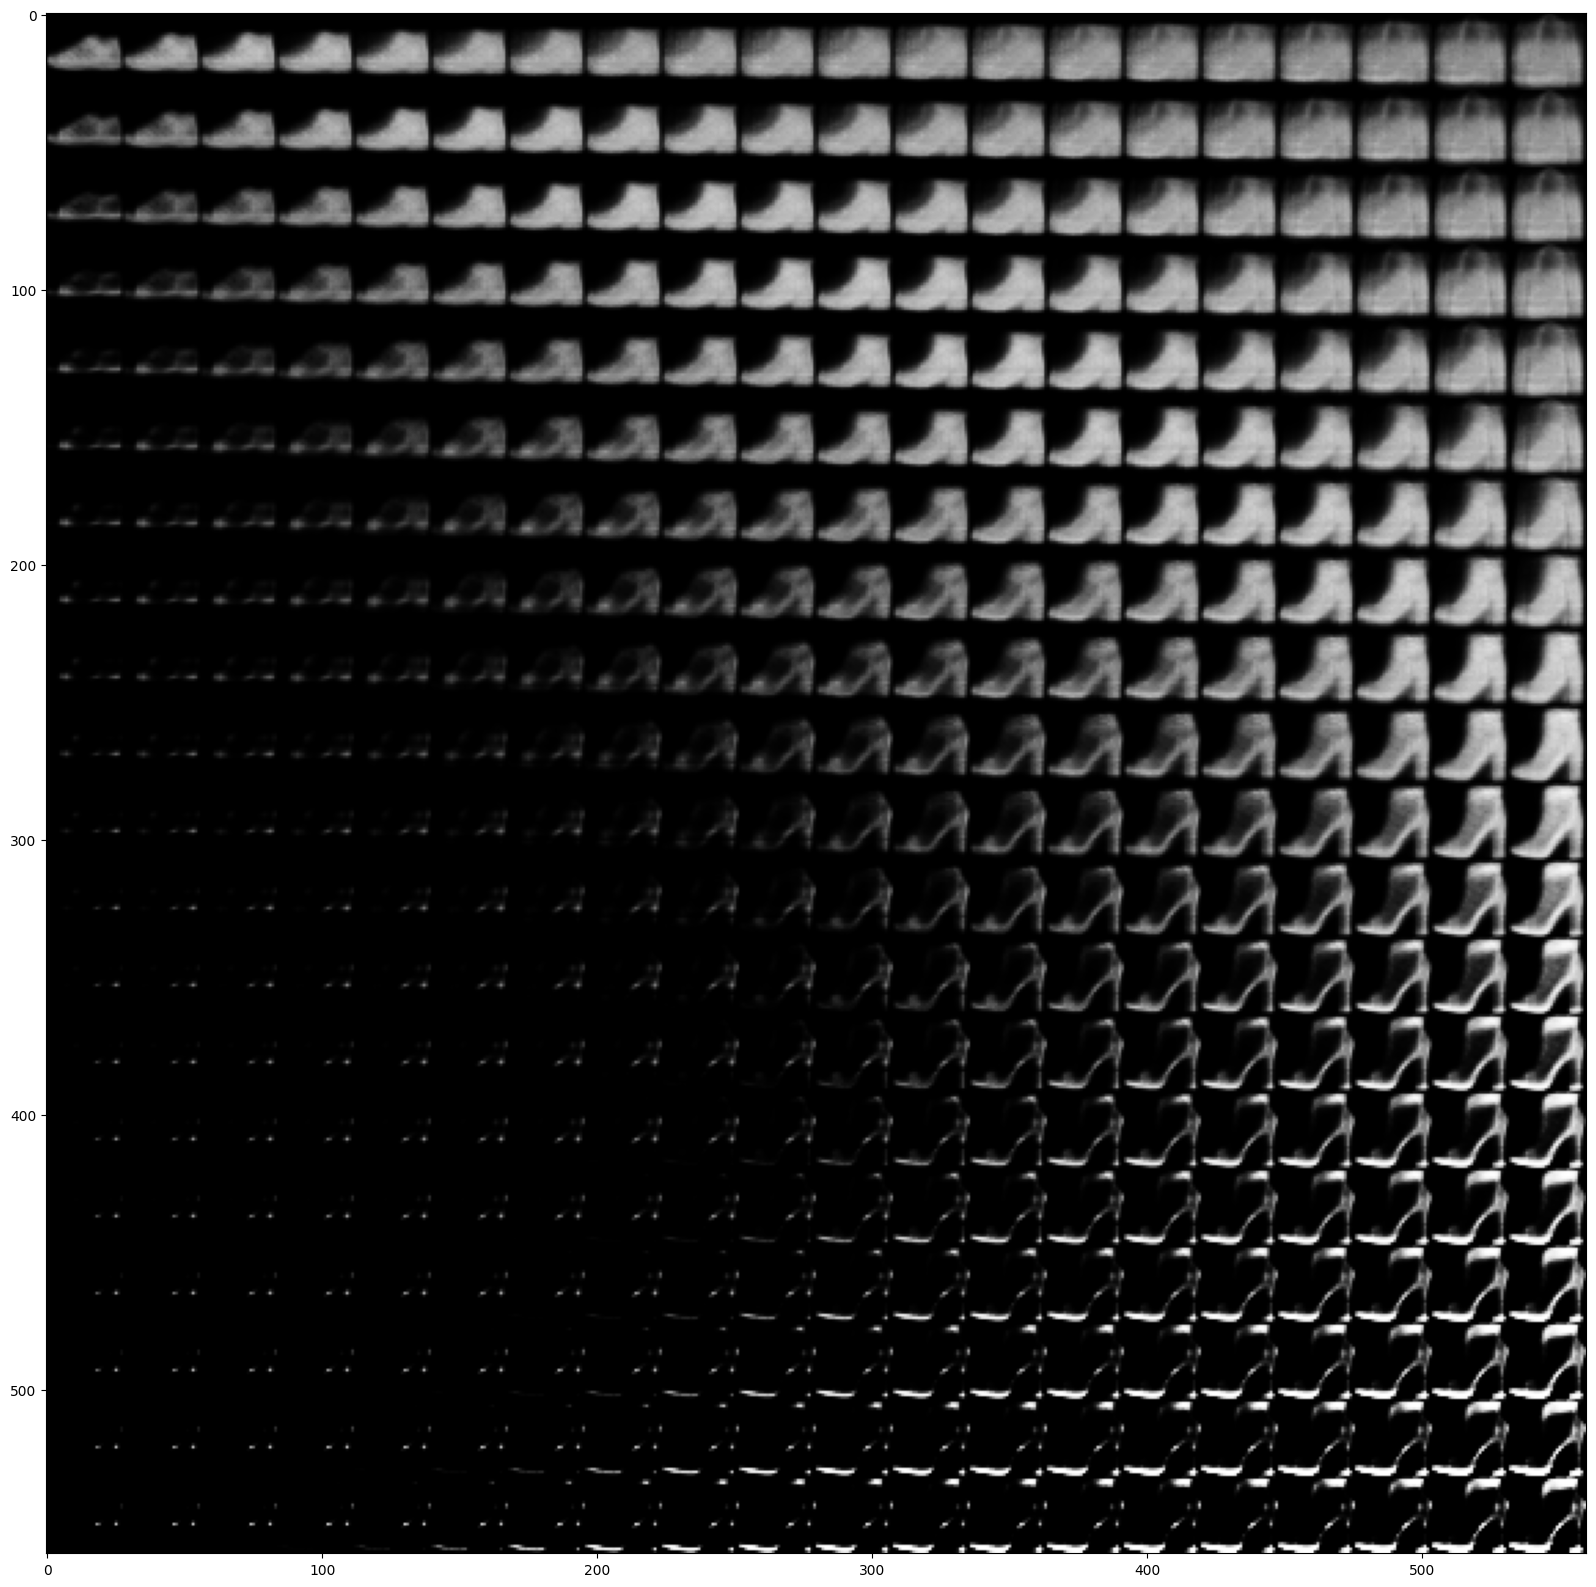

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

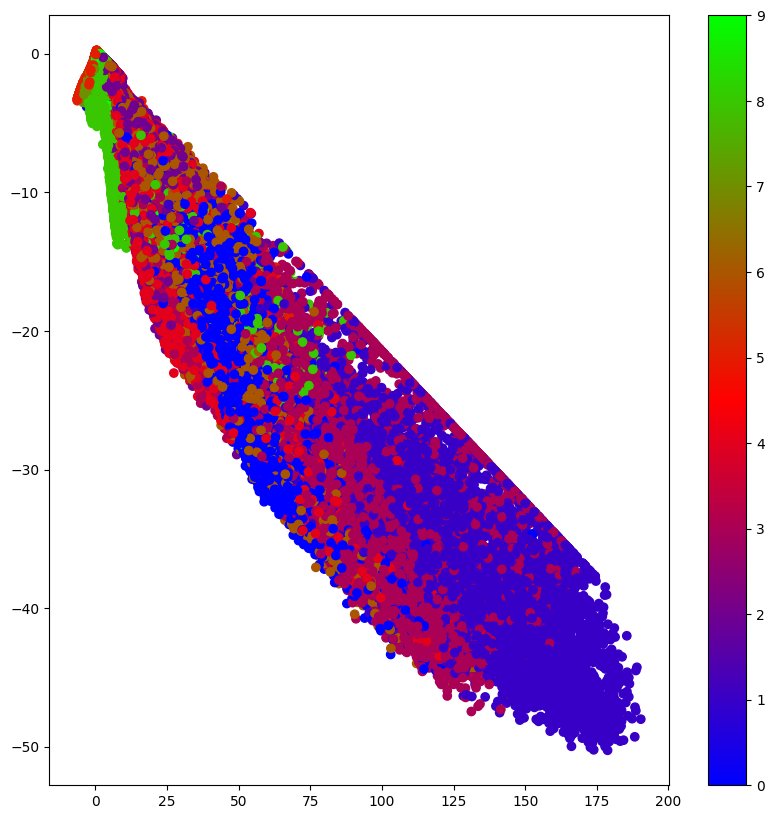

In [ ]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

#### **The VAE's encoder takes the input image and maps it to a latent space with two dimensions then the decoder reconstructs the input image from the latent space. Each dimension in the latent space represents a feature of the data. After training, the data points and 2D manifold of samples was shown by decoding points on a grid in the latent space.**

## Part 2B: Adding CNNs and KL Divergence Losses

### Generating new fashion

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32,3,padding='same', activation='relu')(input_img)
x = Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Setup Sampling Function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network
Task: Try different number of hidden layers and nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Setup Loss Function

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_8[0][0]']               
                                                                                            

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 31s 517us/sample - loss: 0.3601 - val_loss: 0.3423
Epoch 2/20
60000/60000 [==============================] - 31s 516us/sample - loss: 0.3342 - val_loss: 0.3325
Epoch 3/20
60000/60000 [==============================] - 31s 510us/sample - loss: 0.3308 - val_loss: 0.3313
Epoch 4/20
60000/60000 [==============================] - 32s 536us/sample - loss: 0.3289 - val_loss: 0.3291
Epoch 5/20
60000/60000 [==============================] - 28s 475us/sample - loss: 0.3275 - val_loss: 0.3282
Epoch 6/20
60000/60000 [==============================] - 30s 495us/sample - loss: 0.3265 - val_loss: 0.3275
Epoch 7/20
60000/60000 [==============================] - 33s 547us/sample - loss: 0.3258 - val_loss: 0.3267
Epoch 8/20
60000/60000 [==============================] - 28s 467us/sample - loss: 0.3251 - val_loss: 0.3288
Epoch 9/20
60000/60000 [==============================] - 31s 517us/sample - l

### Visualize Samples Reconstructed by VAE

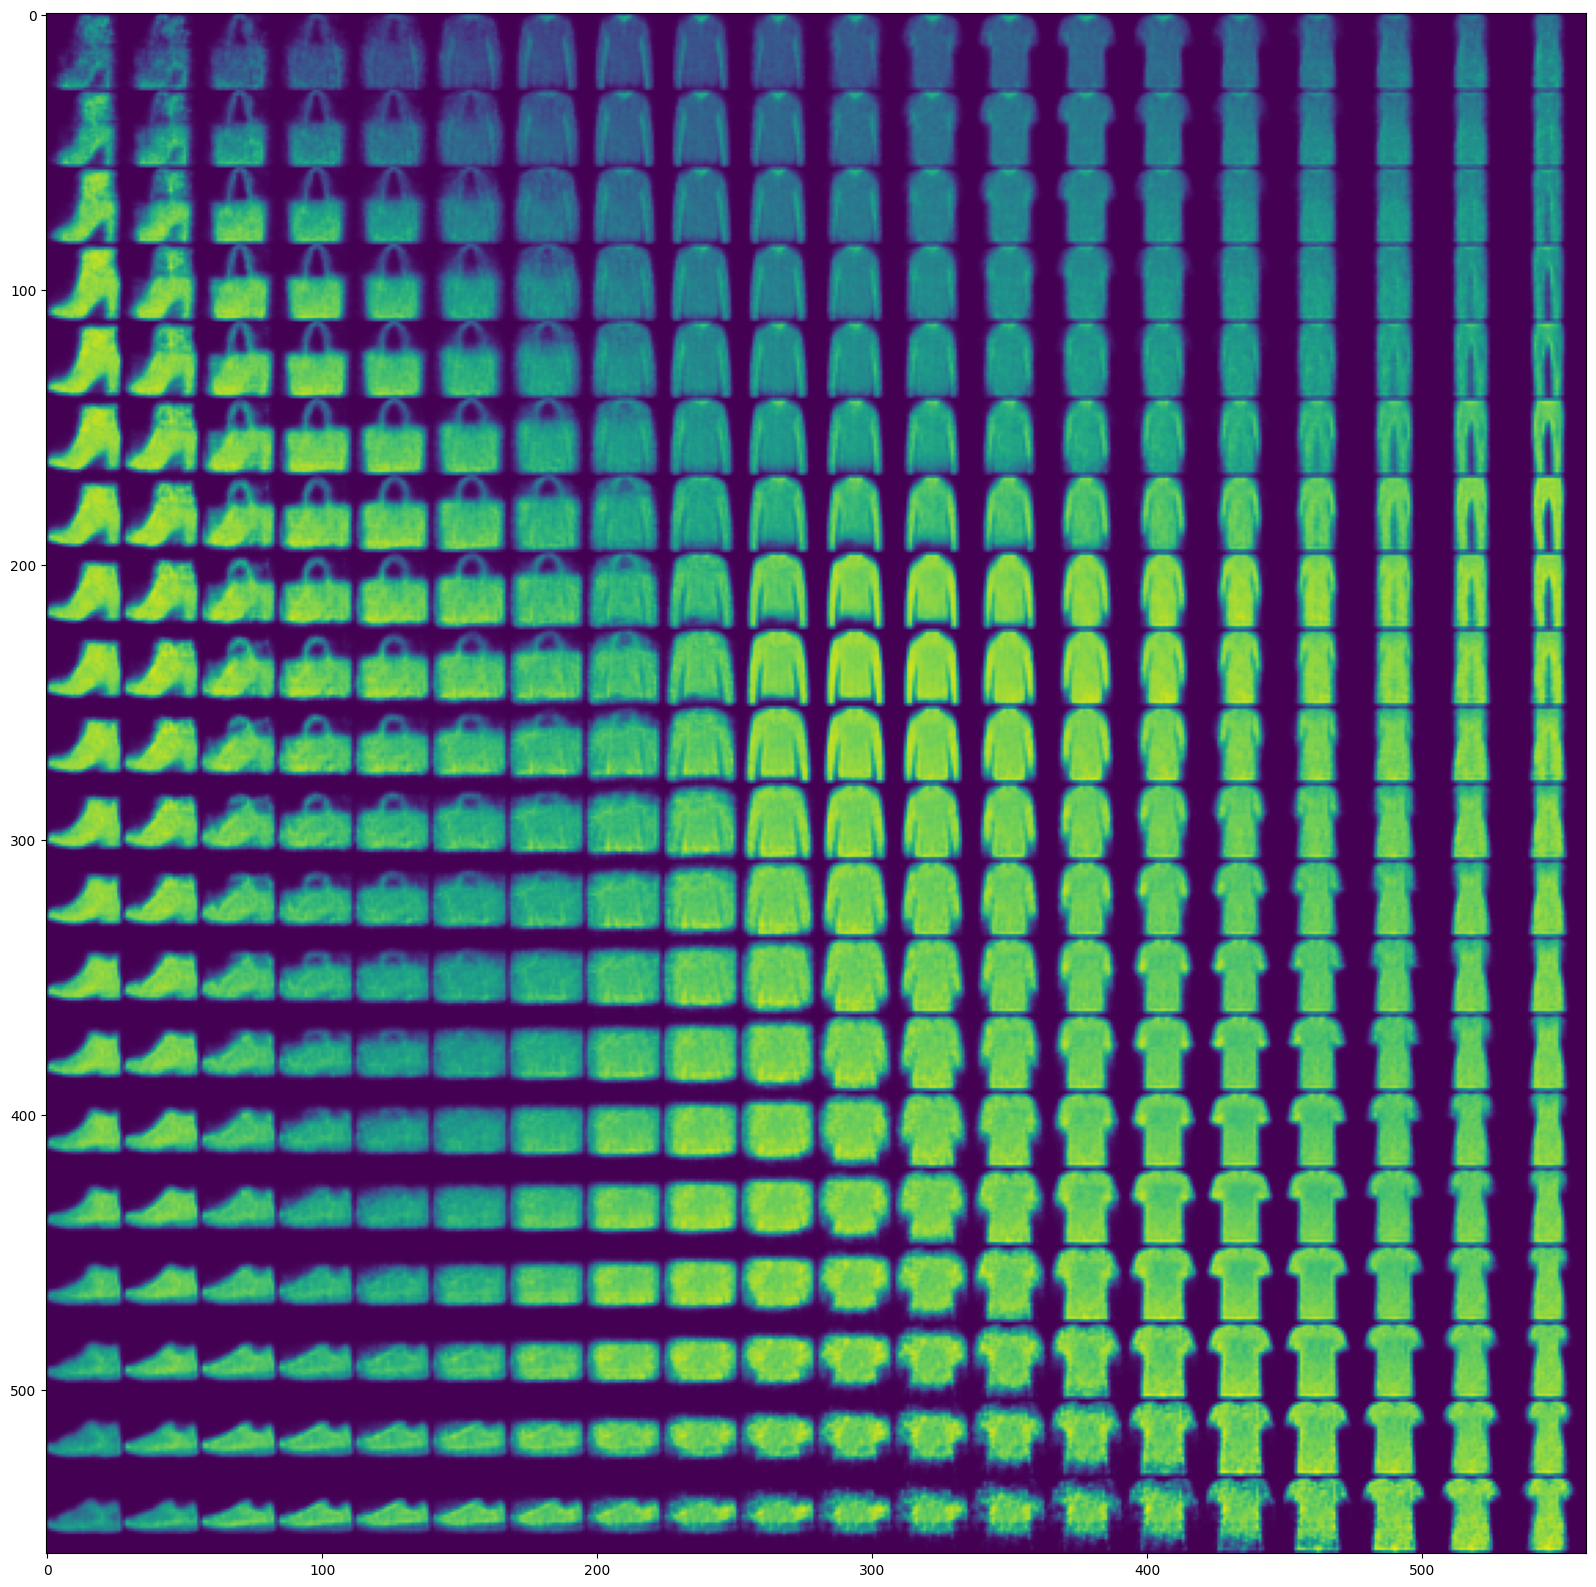

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### VAE: Visualize Latent Space

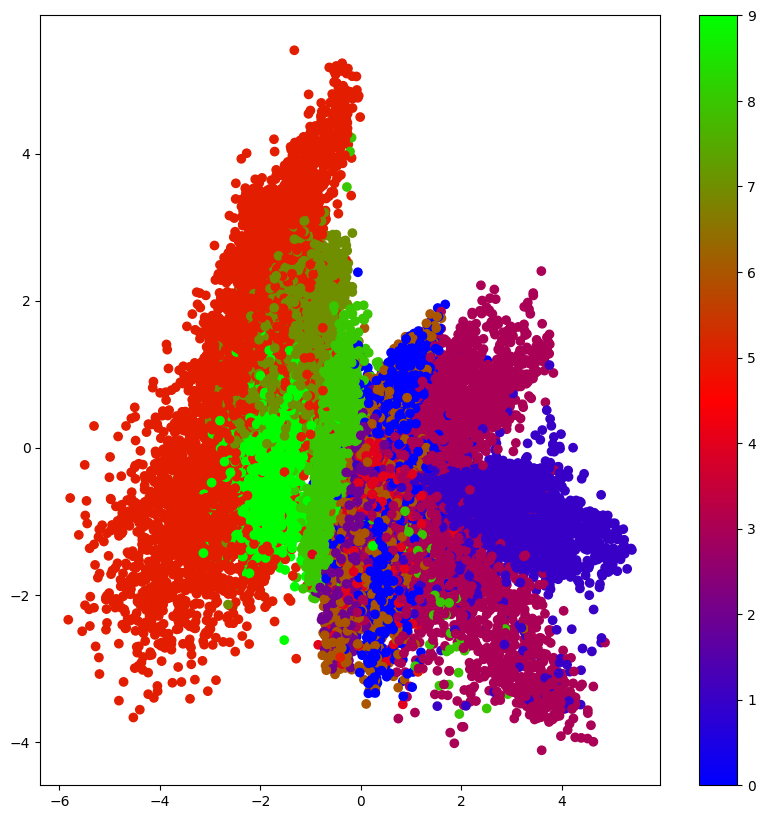

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Exercise: Generating a 1D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

A general function to define feedforward architectures

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))

  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))

  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

Setting GAN training and losses here

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
# hyper-parameters
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1,epochs+1):

        # generate noise from a uniform distribution
        noise = np.random.rand(batch_size,NOISE_DIM)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)

        #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
        #the generator may just produce these features only to exploit the discriminator.
        #The optimization may turn too greedy and produces no long term benefit.
        #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        # Train generator
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                128       
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 193
Trainable par

None


1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  0.9835058483996229 , GAN : [0.02938064]
3rd order moment -  True :  -0.012431196933646596 , GAN : [-1.9208634e-05]
4th order moment -  True :  2.935144798975937 , GAN : [0.00235253]


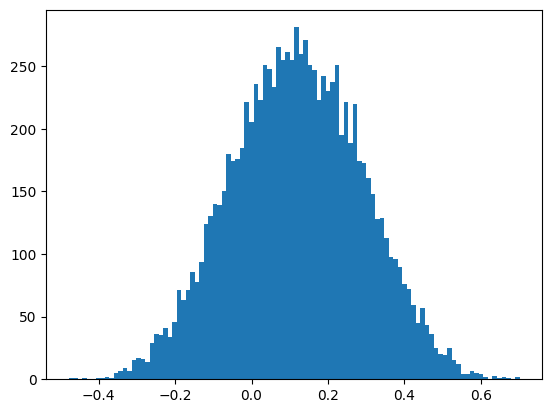

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

**CONCLUSION**

Some conclusions we can make from this exercise:
1. GANs are able to learn a generative model from general noise distributions.
2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)


# Supplementary Activities

## Part 1: MNIST GAN - Learn to Generate MNIST Digits

#### **Trying Autoencoder in MNIST**

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Re-scale data since we are using ReLU activations. **WHY?**

#### **Rescaling the data necessary when using ReLU activations in neural networks, including autoencoders. This is because ReLU can lead to a problem like "dying ReLU neurons." When the input to a ReLU neuron is negative, the neuron outputs zero which makes it inactive. If a large portion of the data is negative, it can prevent the learning process. Rescaling the data helps lessen this issue by shifting the data distribution to be centered around zero or positive values.**

In [ ]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
noise_val = 0.1

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
noise = augmenters.SaltAndPepper(noise_val)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(X_train_n, X_train, epochs=20, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0307 - val_loss: 0.0258
Epoch 2/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0242 - val_loss: 0.0222
Epoch 3/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0215 - val_loss: 0.0205
Epoch 4/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0197 - val_loss: 0.0188
Epoch 5/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0184 - val_loss: 0.0175
Epoch 6/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0175 - val_loss: 0.0168
Epoch 7/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0169 - val_loss: 0.0165
Epoch 8/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0162 - val_loss: 0.0156
Epoch 9/20
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0157 - val_

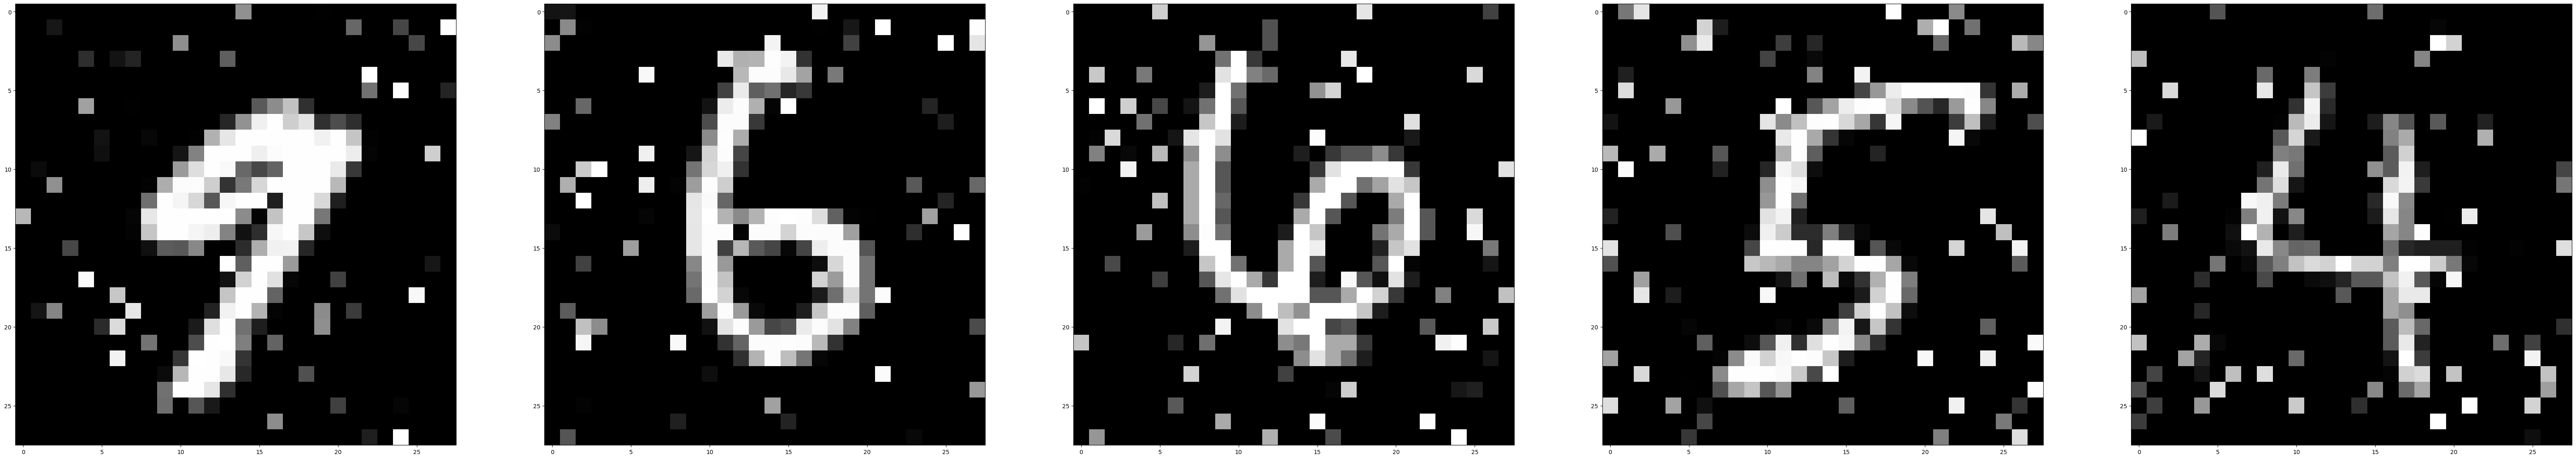

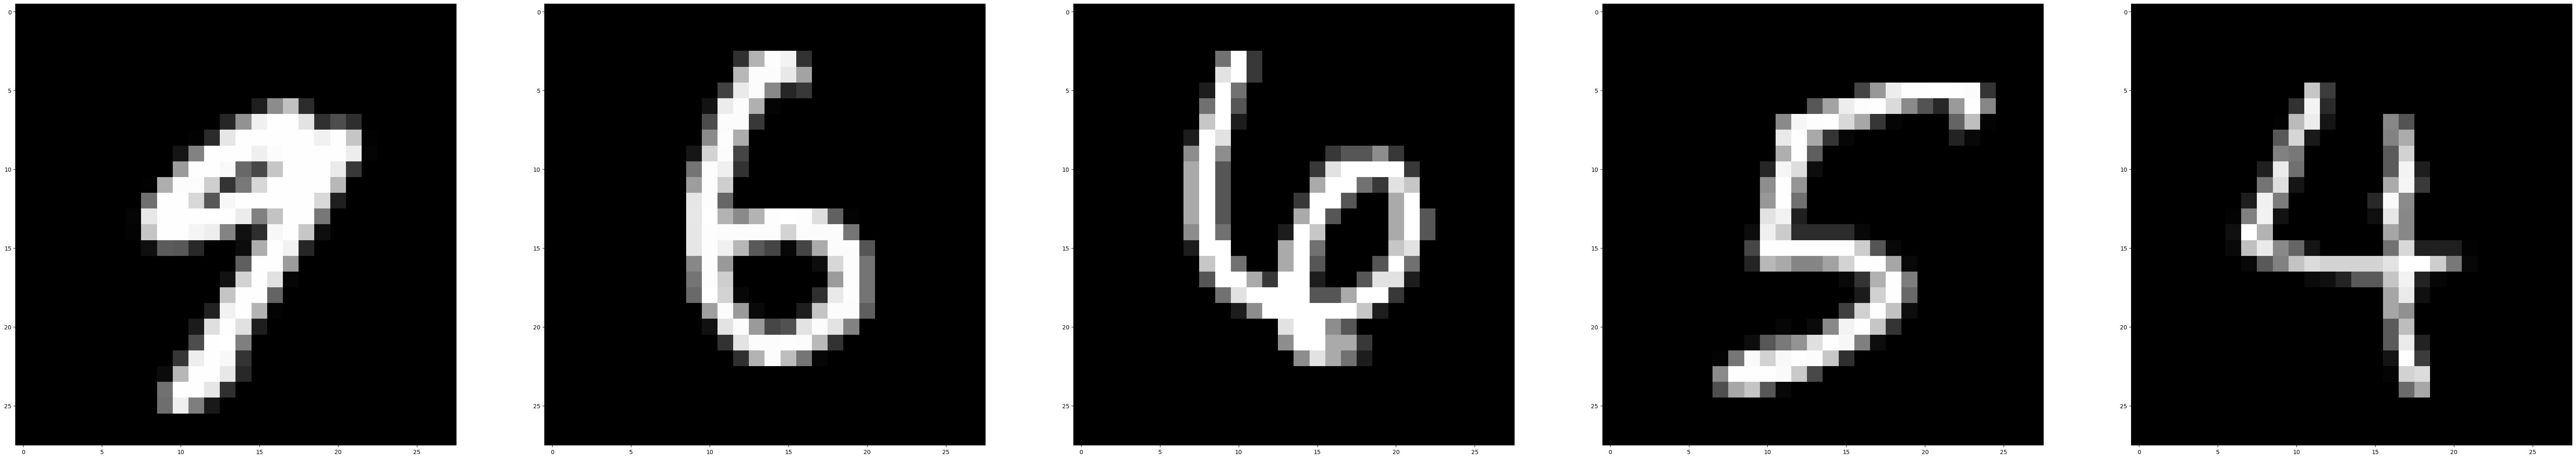

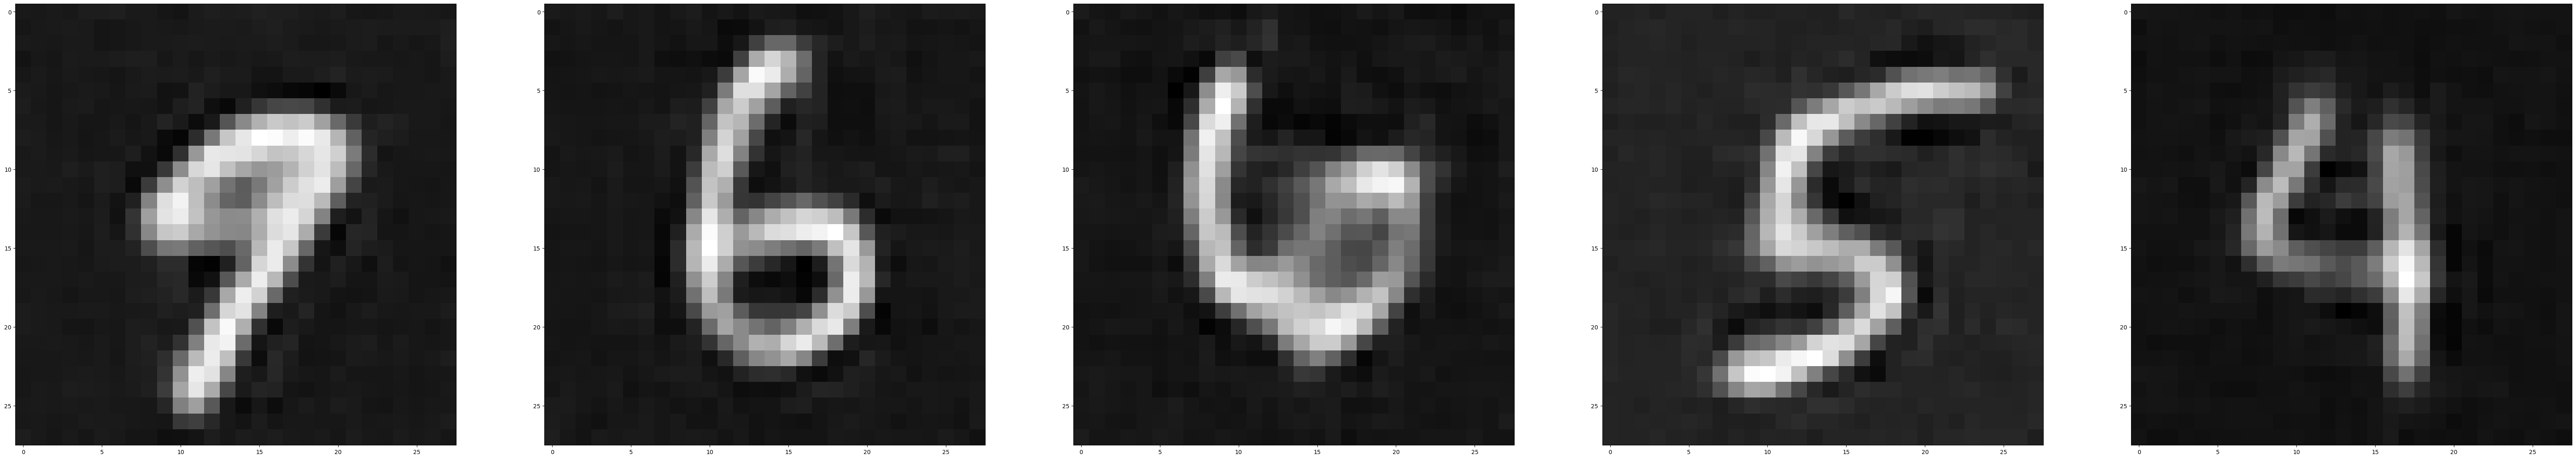

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i, a in enumerate(range(n, n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')

plt.show()

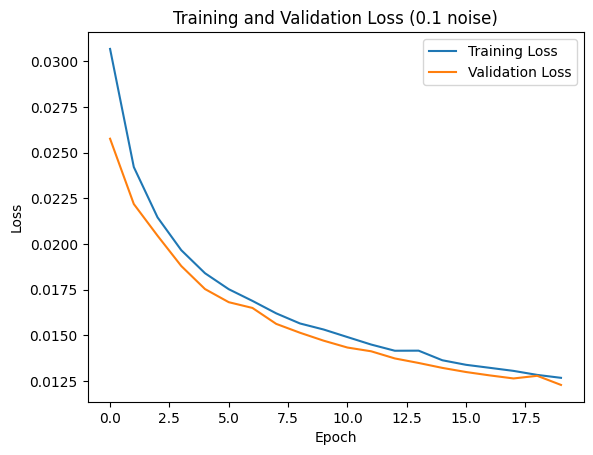

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (0.1 noise)')
plt.legend()

# Show plot
plt.show()

#### **Using the vanilla autoencoder, the loss decreases as the epochs increases. Also, by observing the predicted images, it somehow similar to the original even though it was trained with a noise level of 0.1. This indicates that the autoencoder is learning to reconstruct the input data despite the added noise.**

Set noise dimension

**EXERCISE : Play around with different noise dimensions and plot the performance with respect to the size of the noise vector.**

Tasks:
1. Build Model using LeakyReLU Activations: Build a generator, discriminator, and a GAN as feed-forward network with multiple layers, dropout, and leakyReLU as activation function.
2. Train Model
3. Provide an evaluation/conclusion.

In [ ]:
z_dim = 100

In [ ]:
def generate_data(n_samples = 10000, n_dim=1):
  return np.random.randn(n_samples, n_dim)

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64, n_layers=1, activation='LeakyReLU', optimizer='adam', loss='binary_crossentropy', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim))
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))  # dropout layer

    for _ in range(n_layers-1):
        model.add(Dense(hidden_dim))
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))  # dropout layer

    model.add(Dense(output_dim, activation=activation))

    model.compile(loss=loss, optimizer=optimizer)
    print(model.summary())
    return model

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
DATA_DIM = 1
G_LAYERS = 8
D_LAYERS = 15

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(z_dim, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, z_dim, generator, 'adam')

    for e in range(1,epochs+1):

        noise = np.random.rand(batch_size,z_dim)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        noise = np.random.rand(batch_size,z_dim)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)               

#### **Noise dimension: 100**

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0023873512517416 , GAN : [0.01865403]
3rd order moment -  True :  -0.029320801482458744 , GAN : [0.00063599]
4th order moment -  True :  3.0113410059002192 , GAN : [0.00102722]


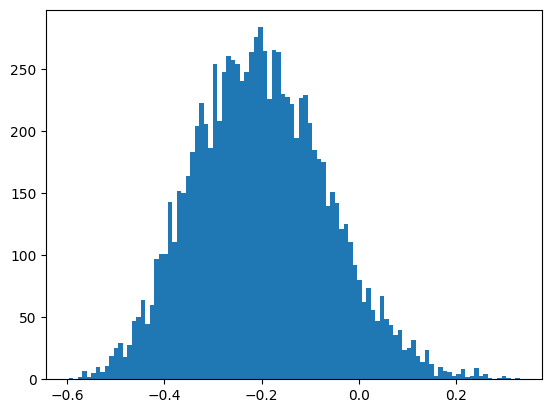

In [ ]:
noise = np.random.rand(10000,z_dim)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

#### **Noise dimension: 50**

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  0.9948284303228815 , GAN : [0.02609989]
3rd order moment -  True :  -0.017653403289811534 , GAN : [0.0013026]
4th order moment -  True :  3.0230981270100794 , GAN : [0.00193893]


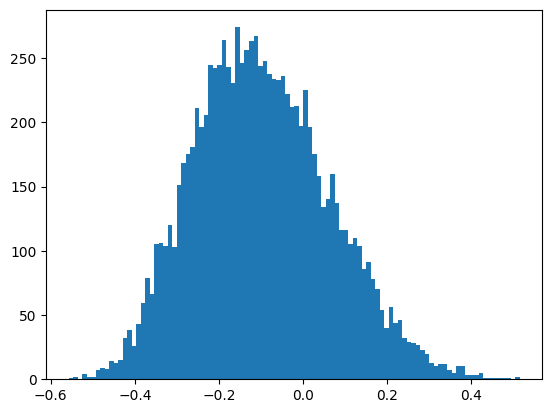

In [ ]:
noise = np.random.rand(10000,z_dim)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

#### **Noise dimension: 20**

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0232122943397097 , GAN : [0.01470771]
3rd order moment -  True :  -0.009861114861655201 , GAN : [-0.00081424]
4th order moment -  True :  3.11175056071828 , GAN : [0.00065372]


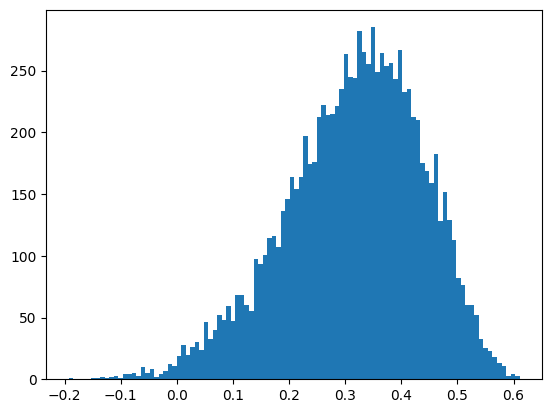

In [ ]:
noise = np.random.rand(10000,z_dim)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

#### **Evaluation:**

#### **In all noise dimensions, both the true distribution and the GAN-generated samples has a mean of 0. This means that the GAN is learning to generate noise centered around zero. However, as the dimension decreases from 100-20, the GAN-generated distributions start to have more difference from the true distributions. Basically, the results become less accurate in representing the statistical properties of the real data as we decrease the noise dimension.  Moreover, based on the graphs, it’s clear that the noise dimension of 100 has somehow the most symmetrical distributions compared to 50 and 20.**




-------

## Part 2: GANs and VAEs

Tasks:
1. Use your own dataset.
2. Generate new images using GAN and VAE
3. Compare the results of generating images using GAN and VAE.

**GAN:**

In [ ]:
from keras.datasets.cifar10 import load_data
(trainX, _), (_, _) = load_data()
X_train = trainX.astype('float32')
X_train = (X_train - 127.5) / 127.5

In [ ]:
latent_dim = 100

# Discriminator
discriminator_model = Sequential()
discriminator_model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
discriminator_model.add(LeakyReLU(alpha=0.2))
discriminator_model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator_model.add(LeakyReLU(alpha=0.2))
discriminator_model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator_model.add(LeakyReLU(alpha=0.2))
discriminator_model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
discriminator_model.add(LeakyReLU(alpha=0.2))
discriminator_model.add(Flatten())
discriminator_model.add(Dropout(0.4))
discriminator_model.add(Dense(1, activation='sigmoid'))
optimizer_d = Adam(lr=0.0002, beta_1=0.5)
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])

In [ ]:
# Generator
generator_model = Sequential()
size = 256 * 4 * 4
generator_model.add(Dense(size, input_dim=latent_dim))
generator_model.add(LeakyReLU(alpha=0.2))
generator_model.add(Reshape((4, 4, 256)))
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(LeakyReLU(alpha=0.2))
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(LeakyReLU(alpha=0.2))
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(LeakyReLU(alpha=0.2))
generator_model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

In [ ]:
# GAN
discriminator_model.trainable = False
gan_model = Sequential()
gan_model.add(generator_model)
gan_model.add(discriminator_model)
optimizer_g = Adam(lr=0.0002, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=optimizer_g)

In [ ]:
# Train the generator and discriminator
n_epochs = 10
n_batch = 128
bat_per_epo = int(X_train.shape[0] / n_batch)
half_batch = int(n_batch / 2)
for i in range(n_epochs):
    for j in range(bat_per_epo):
        # Train discriminator
        X_real, y_real = X_train[randint(0, X_train.shape[0], half_batch)], ones((half_batch, 1))
        d_loss_real, _ = discriminator_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generator_model.predict(randn(latent_dim * half_batch).reshape(half_batch, latent_dim)), zeros((half_batch, 1))
        d_loss_fake, _ = discriminator_model.train_on_batch(X_fake, y_fake)
        # Train generator
        X_gan = randn(latent_dim * n_batch).reshape(n_batch, latent_dim)
        y_gan = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print('>%d, %d/%d, d_real=%.3f, d_fake=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>4, 231/390, d_real=0.612, d_fake=0.529 g=1.266
2/2 [==============================] - 0s 4ms/step
>4, 232/390, d_real=0.562, d_fake=0.790 g=1.243
2/2 [==============================] - 0s 6ms/step
>4, 233/390, d_real=0.617, d_fake=0.530 g=1.197
2/2 [==============================] - 0s 5ms/step
>4, 234/390, d_real=0.601, d_fake=0.690 g=1.286
2/2 [==============================] - 0s 5ms/step
>4, 235/390, d_real=0.450, d_fake=0.483 g=1.510
2/2 [==============================] - 0s 5ms/step
>4, 236/390, d_real=0.580, d_fake=0.523 g=1.642
2/2 [==============================] - 0s 4ms/step
>4, 237/390, d_real=0.471, d_fake=0.508 g=1.701
2/2 [==============================] - 0s 5ms/step
>4, 238/390, d_real=0.487, d_fake=0.653 g=1.812
2/2 [==============================] - 0s 5ms/step
>4, 239/390, d_real=0.625, d_fake=0.706 g=2.020
2/2 [==============================] - 0s 4ms/step
>4, 240

1/1 [==============================] - 0s 33ms/step


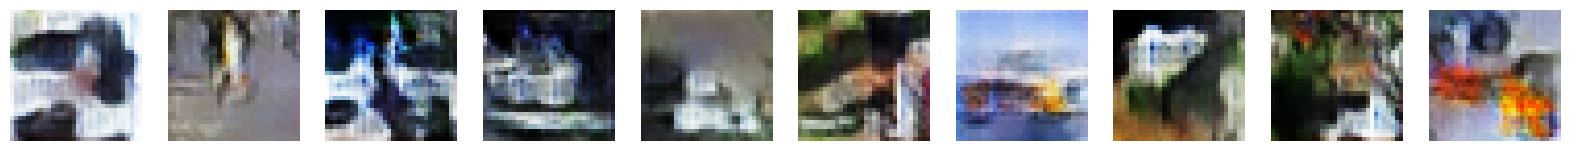

In [ ]:
# Generate reconstructed images
latent_points = randn(latent_dim * 10).reshape(10, latent_dim)
X_reconstructed = generator_model.predict(latent_points)

# Plot reconstructed images
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow((X_reconstructed[i] + 1) / 2)
    plt.axis('off')
plt.show()

#### **The image the GAN made isn't very clear yet since it was just trained for 10 epochs. This is somehow understandable since it happens in fewer training where the images can look blurry and there’s a lack in details. However, with adding more epochs, it can be able to improve its performance to generate a higher quality image.**

**VAE:**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
latent_dim = 64

In [ ]:
# Encoder
encoder_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation='relu')(decoder_input)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_output = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

In [ ]:
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoder_output, name='decoder')
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name='vae')

In [ ]:
# Loss function
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)

In [ ]:
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(x_train, epochs=30, batch_size=80, validation_data=(x_test, None))

Epoch 1/30
625/625 [==============================] - 12s 9ms/step - loss: 0.6825 - val_loss: 0.6789
Epoch 2/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6771 - val_loss: 0.6773
Epoch 3/30
625/625 [==============================] - 5s 7ms/step - loss: 0.6745 - val_loss: 0.6712
Epoch 4/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6703 - val_loss: 0.6714
Epoch 5/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6699 - val_loss: 0.6701
Epoch 6/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6695 - val_loss: 0.6698
Epoch 7/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6695 - val_loss: 0.6699
Epoch 8/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6695 - val_loss: 0.6699
Epoch 9/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6693 - val_loss: 0.6696
Epoch 10/30
625/625 [==============================] - 5s 8ms/step - loss: 0.6694 - val_loss: 0.669

1/1 [==============================] - 0s 344ms/step


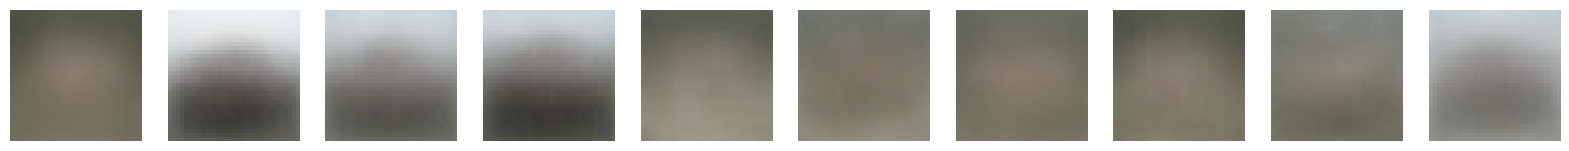

In [ ]:
reconstructed_images = vae.predict(x_test[:10])
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
plt.show()

#### **The results of reconstructed images are unfortunately blurry, and the loss is decreasing slowly in every epochs. This means that VAE's architecture for encoder and decoder leads to poor performance. Moreover, the model is having difficulty in learning significant representations of the data. Experimenting more about different structures andd hyperparameters will be necessary to improve its performance.**

#### **Comparison**

1/1 [==============================] - 0s 33ms/step


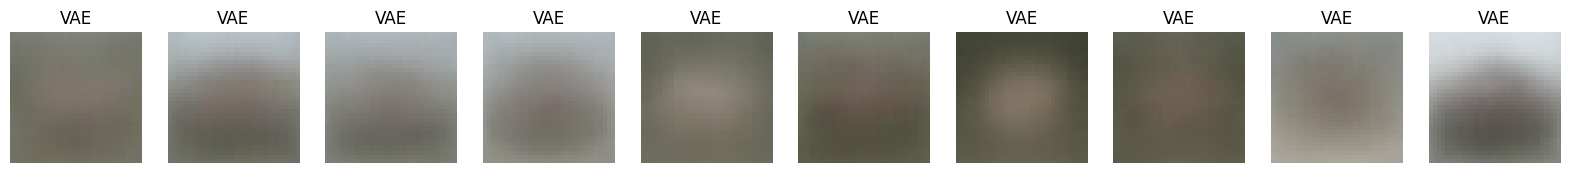

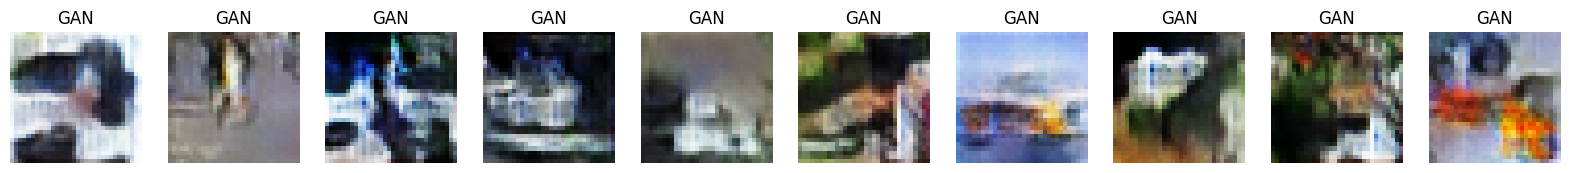

In [ ]:
reconstructed_images = vae.predict(x_test[:10])
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    plt.title("VAE")
plt.show()
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow((X_reconstructed[i] + 1) / 2)
    plt.axis('off')
    plt.title("GAN")
plt.show()

#### **Comparing the two results when it comes to generating images, GAN trained for 10 epochs outperformed VAE which is trained for 30 epochs. GAN produced sharper and more realistic images especially if more epochs will be added during the training. It focuses on creating high-quality samples that can fool the discriminator. Meanwhile, VAE produced blurry images and had difficulty in reconstructing the images. It might also because of its model's architecture that needs to be improved.**

------------------------
#### **Conclusion**

#### **To sum up, Autoencoder (AE) is a neural network that compresses input data into a lower-dimensional representation with the use of an encoder and a decoder for reconstruction. It aims to have lesser RE. VAEs' goal is to maximize the probability of the generated output with respect to the input then produce an output from a target distribution by compressing the input into a latent space. On the other hand, GANs consist of the generator and the discriminator. The generator used to produce synthetic images from the original ones with random noise to fool the discriminator, while the discriminator classifies the images created by the generator then decide whether they are fake or original.**

# References


> **Variational Autoencoders and GANs**
>
> Harvard University
>
> Fall 2020
>
> Instructors: Mark Glickman, Pavlos Protopapas, and Chris Tanner
>
> Lab Instructors: Chris Tanner and Eleni Angelaki Kaxiras
>
> Content: Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner
>
> Link: https://harvard-iacs.github.io/2020-CS109B/labs/lab10/notebook/

